# Big Data Visualization of Neuron Spike Times as Fuzzy Point Processes
Tim Tyree<br>
6.4.2021

In [1]:
# #automating the boring stuff can take ~20 seconds here...
from lib.getterdone import *

## Notes:

- The assumptions of UMAP include (i) local connectivity and (ii) samples approximately uniformly distributed over the relevant information manifold.<br>
- By exposing a given marmoset to a controlled audiovisual stimulus, we directly observed the information manifold and compared it to a control (Fig. X).


- TODO(!): use the simplest method of combining two umap plots? np.concatenate... But it doesn't scale to terrabyte sized data sets...

- TODO(later): compute the fuzzy complement of the test umap fit minus the control umap fit
- TODO: i.e. intersect the (optimal interval of the) test trial with the (optimal interval of the) corresponding control trial

> "If you are willing to try something a little more experimental there is also a third option using the - operator which effectively intersects with the fuzzy set complement (and is thus not commutative, just as - implies). The goal here is to try to provide a sense of what the data looks like when we contrast it against a second view."

- TODO(later): show reproducibility to machine precision
- HINT: np.all(mapper1.embedding_ == mapper2.embedding_)

In [4]:
#DONE: compute lag durations as before
#DONE: compute labels as before
# TODO: compute the point-process of a given trial
# TODO: find the corresponding control trial
# TODO: compute the point-process of a given trial
# TODO: compute umap on the last 1 second of this given trial. plot.
# TODO: compute umap on the last 1 second of the corresponding control trial. plot.
# TODO: merge ^those into 1 umap. plot.
# TODO: smoosh everything together by changing umap parameters
# TODO: color the test points different from the control points. shade by time.
# TODO: Can I interpret ^that?  
# if not, then
# TODO: try including the whole trial and coloring the points before 1 second of the end differently


In [5]:
# #install the goodies
# !pip install numba --ignore-installed
# !pip install umap-learn
# !pip install umap-learn[plot]
# !pip install umap-learn[parametric_umap]
# # !pip install pandas matplotlib datashader bokeh holoviews scikit-image colorcet
# import hdbscan # leland needs to update hdbscan to work with umap in the same pyenv with numpy version <=1.19

# visualize a single trial 
as a umap plot as the space formed by 2d-Gaussian distributions OR hyperbolic embedding

## import a single trial

In [178]:
#import a chunk of Mike's data, as before.
input_file_name=f"{nb_dir}/Data/spike_times_trial_20.json"
with open(input_file_name) as f:
    data_raw = json.load(f)
# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}
type(data_raw)

dict

In [179]:
#input neuron id
nid_self=20#0
l=nid_self
key_self=list(data_raw.keys())[l]
times_self=np.array(data_raw[key_self],np.float64)
M=times_self.shape[0]

In [180]:
# #represent spiketime trial for 1 neuron as a point process in terms of an 1 x m x n numpy array
N=len(list(data_raw.keys()))
arr = np.full([M, N], np.nan)

#initialize a list of length N=number of neurons
# X=np.full(N,np.nan,dtype=np.float64)
#functionally compute the time since last spike time for a given time for each neuron
for m,t in enumerate(times_self):
    for n,key in enumerate(data_raw.keys()):
        spikes=np.array(data_raw[key],np.float64)
        spikes=spikes[spikes<t]
        if not spikes.shape[0]==0:
            lag=t-spikes[-1]
            arr[m,n]=lag #time since last spike in the nth neuron
            # X[n]=1/lag #rate since last spike in the nth neuron

In [181]:
#find the biggest subsquare with no nan values
#the goal is to have no nan values in arr
#find the fraction of True for each column
boo_neurons_keep=~np.isnan(arr)[-1,:]
for n in range(N):
    earliest_time_thresh=-1
    if boo_neurons_keep[n]:
        boo=np.isnan(arr)[:,n]
        frac=sum(boo)/boo.shape[0]
        #earliest time of nonnan value for given neuron is less than earliest_time_thresh
        boo_neurons_keep[n]=times_self[~boo][0]<earliest_time_thresh

In [182]:
boo_times_keep=times_self>earliest_time_thresh
Mnew=sum(boo_times_keep)
Nnew=sum(boo_neurons_keep)
arrnew=arr[boo_times_keep][:,boo_neurons_keep]
#assert there are no remaining nan values
assert (not np.isnan(arrnew).any())
data=arrnew
data.shape

(74, 188)

In [267]:
#compute spike times
spike_times=np.array(data_raw[f"{nid_self}"])

#classify spikes as before/after the stimulus
t_stim=.15#~150ms for stimulus to reach the neurons in the hippocampus
boo_before_stim=spike_times<t_stim
boo_after_stim=~boo_before_stim
target_names=[r'before',r'after']
target=boo_before_stim*0+boo_after_stim*1
target=target[boo_times_keep]

In [184]:
#classify spikes as before or during the arrival time of the information of the stimulus
t_arrival=1.5 #seconds
t_departure=2.5 #seconds
boo_before=spike_times<t_arrival
boo_after=~boo_before
boo_after&=spike_times<t_departure
boo_ignore=spike_times>=t_departure
target_names=[r'before',r'after',r'ignore']
target=boo_before*0+boo_after*1+boo_ignore*2
target=target[boo_times_keep]

In [185]:
#DONE: set data to the point process array
#DONT: set target to the next spike time
#DONE: change digits.data/target to data/target in any of ^those examples 
#DONE: run those cells!
#DONE: try out the hyperbolic embedding


## fit data

In [264]:
# metric='euclidean'
# metric='mahalanobis'
# metric='cosine'
metric='correlation'
# metric='hellinger'
# metric='wminkowski'

# **Minkowski style metrics**
# metric='chebyshev'
# metric='minkowski'


# **Angular and correlation metrics**
# * cosine
# * correlation

# **Metrics for binary data**
# * hamming
# * jaccard
# * dice
# * russelrao
# * kulsinski
# * rogerstanimoto
# * sokalmichener
# * sokalsneath
# metric='yule'

In [265]:
#show data with a gaussian mapper
gaussian_mapper = umap.UMAP(metric=metric,
                            output_metric='gaussian_energy',
                            n_components=40,
                            random_state=2).fit(data)
x_values=gaussian_mapper.embedding_.T[0]
y_values=gaussian_mapper.embedding_.T[1]
x_origin=5.5
y_origin=3.5
x_values=x_values-x_origin
y_values=y_values-y_origin

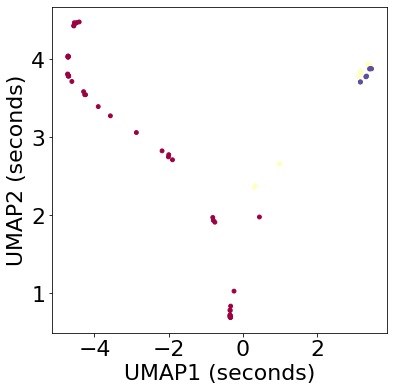

In [266]:
#plot the first two axes
cmap='Spectral'
fontsize=22
fig,ax=plt.subplots(ncols=1,figsize=(6,6))
ax.scatter(x_values, y_values, c=target, cmap='Spectral',s=15)
# ax.scatter(x_values, y_values, 
#             c=target, cmap=cmap, s=1000, marker='.',alpha=0.7)
# ax.scatter(x_values, y_values, 
#             c='k', s=10, marker='.')
ax.tick_params(axis='both',labelsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_xlabel('UMAP1 (seconds)',fontsize=fontsize)
ax.set_ylabel('UMAP2 (seconds)',fontsize=fontsize)
# title='A Single Trial'
# ax.set_title(title,fontsize=fontsize+4)
fig.show()
#                             random_state=42).fit(digits.data)
# plt.scatter(gaussian_mapper.embedding_.T[0], gaussian_mapper.embedding_.T[1], c=digits.target, cmap='Spectral')
# plt.show()

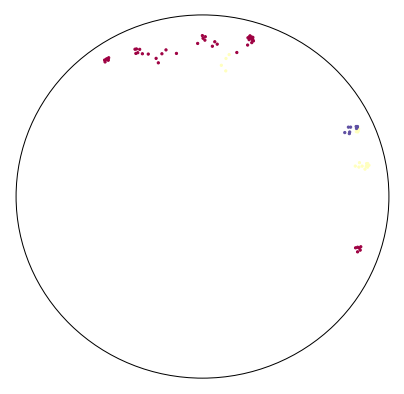

In [262]:
#show data with a hyperbolic embedding
hyperbolic_mapper = umap.UMAP(metric=metric,
                              output_metric='hyperboloid',
                              random_state=2).fit(data)
x = hyperbolic_mapper.embedding_[:, 0]
y = hyperbolic_mapper.embedding_[:, 1]
z = np.sqrt(1 + np.sum(hyperbolic_mapper.embedding_**2, axis=1))
disk_x = x / (1 + z)
disk_y = y / (1 + z)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.scatter(disk_x, disk_y, c=target, cmap='Spectral',s=5)
# ax.scatter(disk_x, disk_y, 
#             c=target, cmap=cmap, s=1000, marker='.',alpha=0.7)
# ax.scatter(disk_x, disk_y, 
#             c='k', s=10, marker='.')
boundary = plt.Circle((0,0), 1.05, fc='none', ec='k')
ax.add_artist(boundary)
ax.axis('off');
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
plt.show()

In [263]:
print('single trial')
print(metric)

single trial
correlation


# visualize many trials

## compute point process feature vectors for an entire set of trials

In [2]:
#load a single set of trials into notebook memory
data_folder=f"{nb_dir}/Data/Archie"
# modname="Archie_SRT_Set212_Subset1_200520_165716_"
modname="Archie_SRT_Set219_subset1_200831_124035_"
t_min_considered, number_of_neurons, dict_spike_times, dict_trial_times, dict_trial_data = load_dataset(modname,data_folder)

106


In [349]:
#time points to take observations
# nid_self=20
nid_self=None #automatically selects the most spiking neuron to be nid_self

In [350]:
#compute the point process model
nid_self,target,data,trialnum_values,t_values=compute_point_process_data(t_min_considered, number_of_neurons, dict_spike_times, dict_trial_times, dict_trial_data,printing=True,nid_self=nid_self)

452 trials successfully parsed into 97832 observations.
this point-process measure is embedded into $\mathbb{R}^{+d}$ real Euclidean space of dimension d=106.


In [351]:
#save as compressed numpy array
save_folder=data_folder
os.chdir(save_folder)
save_fn=modname+f'pointProcess_{nid_self}_compressed.npz'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
np.savez_compressed(save_fn, target=target,data=data,trialnum_values=trialnum_values,t_values=t_values)

In [3]:
nid_self=78
input_dir=f"{nb_dir}/Data/Archie/"+modname+f'pointProcess_{nid_self}_compressed.npz'
dataset=np.load(input_dir)

#extract lag feature vector
data=dataset['data']
target=dataset['target']
trialnum_values=dataset['trialnum_values']
spike_times=dataset['t_values']
target_names=[r'dubious',r'decisive',r'reflective']

In [4]:
input_dir

'/home/timothytyree/Documents/GitHub/neurophysics/notebooks/Data/Archie/Archie_SRT_Set219_subset1_200831_124035_pointProcess_78_compressed.npz'

In [353]:
input_dir

'/home/timothytyree/Documents/GitHub/neurophysics/notebooks/Data/Archie/Archie_SRT_Set219_subset1_200831_124035_pointProcess_78_compressed.npz'

## slice data

In [354]:
#query trials by matching nonnovel experimental conditions
match=True
mismatch=False
novel=False
query=trialnum_values<=0
trialnum_lst=sorted(dict_trial_data.keys())
for trialnum in trialnum_lst:
    #todo: slice where trialnum
    quer=True
    #extract simplified trial condition
    match_code=dict_trial_data[trialnum]['imMatchFlag']
    novel_code=dict_trial_data[trialnum]['novel']
    is_matching=match_code==1
    if match:
        quer&=is_matching
        
    is_mismatching=match_code==2
    if mismatch:
        quer&=is_mismatching    
    
    is_novel=novel_code==1
    if novel:
        quer&=is_novel
    else:
        quer&=~is_novel
    if quer:
        query|=trialnum_values==trialnum

#TODO: select only the dubious/decisive/reflective phase
# query|=target!=0 #don't include dubious
# query|=target!=1 #don't include decisive
# query|=target!=2 #don't include reflective

#TODO: query by computing the boolean index for a given condition
dat=data[query,:]
targ=target[query]

## fit data

In [ ]:
metric='correlation'
kwargs={
    'metric'      :metric,
    'random_state':42,
#     'min_dist'    :0.5,
#     'spread'      :2
}
#fit data to a gaussian mapper
gaussian_mapper = umap.UMAP(
    output_metric='gaussian_energy',
    n_components=2,#n_components=40,
    **kwargs).fit(data)
x_values=gaussian_mapper.embedding_.T[0]
y_values=gaussian_mapper.embedding_.T[1]

# # subtract off the average umap coordinate for each trial
# # for each trial, subtract off the mean
# for trialnum in sorted(set(trialnum_values)):
#     boo=trialnum_values==trialnum
#     x_origin=np.mean(x_values[boo])
#     x_values[boo]=x_values[boo]-x_origin
#     y_origin=np.mean(y_values[boo])
#     y_values[boo]=y_values[boo]-y_origin

In [ ]:
#plot the first two axes
cmap='jet'
fontsize=22
fig,ax=plt.subplots(ncols=1,figsize=(6,6))
ax.scatter(x_values, y_values, 
            c=target, cmap=cmap, s=10, marker='.',alpha=0.7)
# ax.scatter(x_values, y_values, 
#             c=target, cmap=cmap, s=1000, marker='.',alpha=0.7)
# ax.scatter(x_values, y_values, 
#             c='k', s=10, marker='.')
ax.tick_params(axis='both',labelsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_xlabel('UMAP1 (seconds)',fontsize=fontsize)
ax.set_ylabel('UMAP2 (seconds)',fontsize=fontsize)
# title='A Single Trial'
# ax.set_title(title,fontsize=fontsize+4)
fig.show()
#                             random_state=42).fit(digits.data)
# plt.scatter(gaussian_mapper.embedding_.T[0], gaussian_mapper.embedding_.T[1], c=digits.target, cmap='Spectral')
# plt.show()

In [ ]:
hyperbolic_mapper = umap.UMAP(
    output_metric='hyperboloid',**kwargs).fit(data)
x_values = hyperbolic_mapper.embedding_[:, 0]
y_values = hyperbolic_mapper.embedding_[:, 1]
z_values = np.sqrt(1 + np.sum(hyperbolic_mapper.embedding_**2, axis=1))

# subtract off the average umap coordinate for each trial
# for each trial, subtract off the mean
# for trialnum in sorted(set(trialnum_values)):
#     boo=trialnum_values==trialnum
#     x_origin=np.mean(x_values[boo])
#     x_values[boo]=x_values[boo]-x_origin
#     y_origin=np.mean(y_values[boo])
#     y_values[boo]=y_values[boo]-y_origin
#     z_origin=np.mean(z_values[boo])
#     z_values[boo]=z_values[boo]-z_origin

disk_x = x_values / (1 + z_values)
disk_y = y_values / (1 + z_values)

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
# ax.scatter(disk_x, disk_y, c=target, cmap='Spectral')
ax.scatter(disk_x, disk_y,
            c=target, cmap=cmap, s=10, marker='.',alpha=0.7)
# ax.scatter(disk_x, disk_y,
#             c='k', s=10, marker='.')
boundary = plt.Circle((0,0), 1.05, fc='none', ec='k')
ax.add_artist(boundary)
ax.axis('off');
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
plt.show()

# umap on subsets of trials with match versus mismatch conditions

__match_code:__
    - 0 if image only
    - 1 if match (picture and audio monkey identity are the same)
    - 2 if mismatch (picture and audio monkey identity are inconsistent)
    - 3 if audio only

## Showing that all matching cases do not lie on a small number of clear topological manifolds

In [312]:
target,data,trialnum_values

(array([0, 0, 0, ..., 2, 2, 2]),
 array([[3.28000000e-01, 4.67233333e-01, 1.94233333e-01, ...,
         1.31333333e-02, 1.86666667e-02, 1.09666667e-02],
        [2.04133333e-01, 3.05000000e-02, 1.70333333e-02, ...,
         1.06066667e-01, 2.18333333e-02, 1.30433333e-01],
        [2.20300000e-01, 4.66666667e-02, 3.32000000e-02, ...,
         1.22233333e-01, 4.66666667e-03, 9.66666667e-04],
        ...,
        [6.93333333e-03, 2.55533333e-01, 1.36400000e-01, ...,
         4.82056667e+00, 2.52990367e+02, 6.30433333e-01],
        [1.33633333e-01, 4.14066667e-01, 1.43166667e-01, ...,
         4.97910000e+00, 2.53148900e+02, 7.88966667e-01],
        [1.63400000e-01, 4.43833333e-01, 7.23333333e-03, ...,
         5.00886667e+00, 2.53178667e+02, 8.18733333e-01]]),
 array([  3,   3,   3, ..., 452, 452, 452]))

In [321]:
#nota bene, this is done later in pandas in a couple lines...
#query trials by matching nonnovel experimental conditions
match=True
mismatch=False
novel=False
query=trialnum_values<=0
trialnum_lst=sorted(dict_trial_data.keys())
for trialnum in trialnum_lst:
    #todo: slice where trialnum
    quer=True
    #extract simplified trial condition
    match_code=dict_trial_data[trialnum]['imMatchFlag']
    novel_code=dict_trial_data[trialnum]['novel']
    is_matching=match_code==1
    if match:
        quer&=is_matching
        
    is_mismatching=match_code==2
    if mismatch:
        quer&=is_mismatching    
    
    is_novel=novel_code==1
    if novel:
        quer&=is_novel
    else:
        quer&=~is_novel
    if quer:
        query|=trialnum_values==trialnum

#TODO: select only the dubious/decisive/reflective phase
query|=target!=0 #don't include dubious
query|=target!=1 #don't include decisive
# query|=target!=2 #don't include reflective

#TODO: query by computing the boolean index for a given condition
dat=data[query,:]
targ=target[query]

In [322]:
#fit data to a gaussian mapper
gaussian_mapper = umap.UMAP(output_metric='gaussian_energy',
                            n_components=40,
                            random_state=2).fit(dat)
x_values=gaussian_mapper.embedding_.T[0]
y_values=gaussian_mapper.embedding_.T[1]
x_origin=0
y_origin=0
x_values=x_values-x_origin
y_values=y_values-y_origin

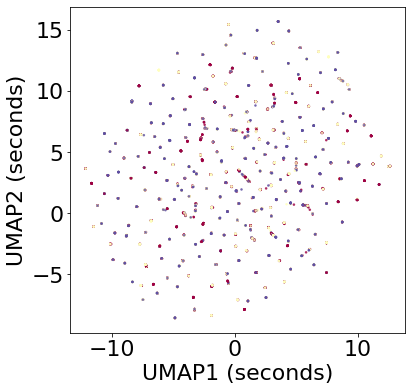

In [323]:
#plot the first two axes
cmap='Spectral'
fontsize=22
fig,ax=plt.subplots(ncols=1,figsize=(6,6))
ax.scatter(x_values, y_values, 
            c=targ, cmap=cmap, s=10, marker='.',alpha=0.7)
# ax.scatter(x_values, y_values, 
#             c=target, cmap=cmap, s=1000, marker='.',alpha=0.7)
# ax.scatter(x_values, y_values, 
#             c='k', s=10, marker='.')
ax.tick_params(axis='both',labelsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_xlabel('UMAP1',fontsize=fontsize)
ax.set_ylabel('UMAP2',fontsize=fontsize)
# title='A Single Trial'
# ax.set_title(title,fontsize=fontsize+4)
fig.show()
#                             random_state=42).fit(digits.data)
# plt.scatter(gaussian_mapper.embedding_.T[0], gaussian_mapper.embedding_.T[1], c=digits.target, cmap='Spectral')
# plt.show()

In [316]:
hyperbolic_mapper = umap.UMAP(output_metric='hyperboloid',
                              random_state=42).fit(dat)
x = hyperbolic_mapper.embedding_[:, 0]
y = hyperbolic_mapper.embedding_[:, 1]
z = np.sqrt(1 + np.sum(hyperbolic_mapper.embedding_**2, axis=1))
disk_x = x / (1 + z)
disk_y = y / (1 + z)

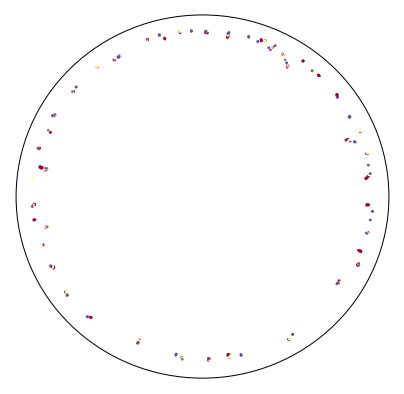

In [317]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.scatter(disk_x, disk_y, 
            c=targ, cmap=cmap, s=10, marker='.',alpha=0.7)
# ax.scatter(disk_x, disk_y, 
#             c=targ, cmap=cmap, s=1000, marker='.',alpha=0.7)
# ax.scatter(disk_x, disk_y, 
#             c='k', s=10, marker='.')
boundary = plt.Circle((0,0), 1.05, fc='none', ec='k')
ax.add_artist(boundary)
ax.axis('off');
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
plt.show()

In [5]:
# #load a single set of trials into notebook memory
# data_folder = f"{nb_dir}/Data/Archie"
# modname = "Archie_SRT_Set212_Subset1_200520_165716_"
# t_min_considered, number_of_neurons, dict_spike_times, dict_trial_times, dict_trial_data = load_dataset(
#     modname, data_folder)
# #import the point process
# #compute the point process model
# nid_self = 10
# nid_self, target, data, trialnum_values, t_values = compute_point_process_data(
#     t_min_considered,
#     number_of_neurons,
#     dict_spike_times,
#     dict_trial_times,
#     dict_trial_data,
#     printing=True,
#     nid_self=nid_self)

# #save as compressed numpy array
# save_folder = data_folder
# os.chdir(save_folder)
# save_fn = modname + f'pointProcess_{nid_self}_compressed.npz'
# if not os.path.exists(save_folder):
#     os.mkdir(save_folder)
# np.savez_compressed(save_fn,
#                     target=target,
#                     data=data,
#                     trialnum_values=trialnum_values,
#                     t_values=t_values)

# # input_dir=f"{nb_dir}/Data/Archie/"+'Archie_SRT_Set212_Subset1_200520_165716_pointProcess_20_compressed.npz'
# input_dir = save_fn
# dataset = np.load(input_dir)
# # dict_trial_data

## all matching cases for a given monkey & orientation is repeatable for short time scales
there are were 2 manifolds when restricting Archie's model fit data only from the third block, which exhibited 4 matching trials where

In [4]:
print(input_dir)
#computelag feature vector
data = dataset['data']
target = dataset['target']
trialnum_values = dataset['trialnum_values']
spike_times = dataset['t_values']
target_names = [r'dubious', r'decisive', r'reflective']

/home/timothytyree/Documents/GitHub/neurophysics/notebooks/Data/Archie/Archie_SRT_Set219_subset1_200831_124035_pointProcess_78_compressed.npz


In [5]:
# #compute rate of change of lag feature vector
# DT_values=np.diff(dataset['t_values'])
# # DT_thresh=10#1
# # boo=np.abs(DT_values)<DT_thresh
# boo=np.diff(dataset['trialnum_values'])==0
# DX_values=np.diff(dataset['data'],axis=0)
# # Y_values=np.divide(DX_values,DT_values,axis=0)
# Y_values=np.stack([DX_values[:,j]/DT_values for j in range(DX_values.shape[1])],axis=1)
# print(Y_values.shape)
# data=Y_values[boo,:]
# spike_times=dataset['t_values'][1:][boo]
# target=dataset['target'][1:][boo]
# trialnum_values=dataset['trialnum_values'][1:][boo]
# target_names=[r'dubious',r'decisive',r'reflective']

In [6]:
# #compute moving average lag feature vector
# navg=1
# data=dataset['data']
# target=dataset['target']
# trialnum_values=dataset['trialnum_values']
# spike_times=dataset['t_values']
# target_names=[r'dubious',r'decisive',r'reflective']
# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w
# x_lst=[]
# for x in data.T:
#     x_lst.append(moving_average(x, w=navg))
# data=np.stack(x_lst).T
# target=moving_average(dataset['target'], w=navg)
# trialnum_values=moving_average(dataset['trialnum_values'], w=navg)
# spike_times=moving_average(dataset['t_values'], w=navg)
# boo=np.diff(moving_average(dataset['trialnum_values'], w=navg))==0
# data=data[1:][boo,:]
# spike_times=spike_times[1:][boo]
# target=dataset['target'][int((navg+1)/4):-int((navg+1)/4)-1][boo]
# trialnum_values=trialnum_values[1:][boo]
# data.shape

In [7]:
# print( dataset['trialnum_values'][:250])
# print( dataset['target'][:250])

In [5]:
df = pd.DataFrame(dict_trial_data).T
df['PicID_1'] = [s.lower() for s in df['PicID_1'].values]
df.head()

#TODO(later): compute rate of change of rate feature vector
#TODO: try concatenating feature vectors
#TODO: subdivide by monkey type
#TODO: make a 4 panel for Archie recognizing each monkey
#TODO: make a 4x4 panel for each monkey recognizing each other monkey. Leave diagonal entries blank for now if their not shown themselves

,imName,imNum,imPheeName,imMatchFlag,novel,imOff,vpltTrial,Block,PheeID,PicID_1,PicID_2,PidID_3
1,HanLeftGood2.JPG,2,han,3,1,2.59139930641925,1,1,han,none,none,none
2,ChewieFrontGood7.JPG,3,hermes,3,1,2.10790857611096,1,1,hermes,none,none,none
3,JennyRightGood2.JPG,4,none,0,1,3.50815615808961,1,1,none,jenny,Right,4
4,CopperFrontGood2.jpg,5,none,0,1,3.50856733147015,1,1,none,copper,Front,5
5,JennyRightGood2.JPG,4,none,0,0,3.50791238056217,1,1,none,jenny,Right,4


In [6]:
# PicID_1_lst=sorted(set(df.PicID_1.values))
PheeID_lst=sorted(set(df.PheeID.values))
orientation_lst=sorted(set(df.PicID_2.values))
imname_lst=sorted(set(df.imName.values))
print(orientation_lst)
print(sorted(set(df.imPheeName.values)))
# print(imname_lst)

['Front', 'Left', 'Right', 'none']
['aladdin', 'ares', 'chewie', 'copper', 'dip', 'han', 'hank', 'hermes', 'jasmine', 'mowgli', 'none', 'poseidon', 'raja', 'waylon']


In [7]:
# monkname=PheeID_lst[4]
monkname=PheeID_lst[3]#cooper
# orientation='Front'#'none'
boo=df.vpltTrial==1 # as stimulus was presented
boo&=df.imPheeName==monkname
boo&=df.PheeID==monkname
trialnum_include_values=df[boo].index.values
print(f"trials available: {trialnum_include_values}")
print(f"Blocks available: {set(df[boo].Block.values)}")

trials available: [ 61  64 140 141 147 148 196 198]
Blocks available: {8, 17, 23}


In [11]:
#select a particular block
blocknum=17#21#3
boo2=boo&(df.Block==blocknum)
trialnum_include_values=df[boo2].index.values
print(f"trials available: {trialnum_include_values}")
# print(f"Blocks available: {set(df[boo].Block.values)}")

trials available: [140 141 147 148]


In [8]:
#query trials by trialnum_include_values
match=True
mismatch=False
novel=False
query=trialnum_values<=0
for trialnum in trialnum_include_values:
    quer=True
    #extract simplified trial condition
    match_code=dict_trial_data[trialnum]['imMatchFlag']
    novel_code=dict_trial_data[trialnum]['novel']
    is_matching=match_code==1
    if match:
        quer&=is_matching
    
    is_mismatching=match_code==2
    if mismatch:
        quer&=is_mismatching    
    
    is_novel=novel_code==1
    if novel:
        quer&=is_novel
    else:
        quer&=~is_novel
    if quer:
        query|=trialnum_values==trialnum

#query by computing the boolean index for a given condition
dat=data[query,:]
targ=target[query]
# targ=trialnum_values[query]
dat.shape

(405, 106)

In [9]:
#fit data to a gaussian mapper
gaussian_mapper = umap.UMAP(output_metric='gaussian_energy',
                            n_components=2,
                            random_state=42,
                            n_neighbors=50).fit(dat)
x_values=gaussian_mapper.embedding_.T[0]
y_values=gaussian_mapper.embedding_.T[1]
# x_origin=np.mean(x_values)
# y_origin=np.mean(y_values)
# x_values=x_values-x_origin
# y_values=y_values-y_origin

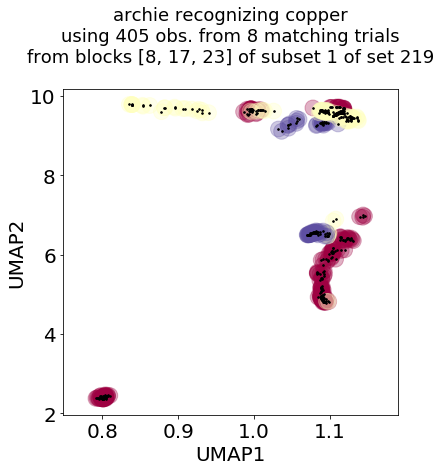

In [10]:
#plot the first two axes
cmap='Spectral'
# cmap='viridis'
fontsize=20
fig,ax=plt.subplots(ncols=1,figsize=(6,6))
# ax.scatter(x_values, y_values, 
#             c=targ, cmap=cmap, s=10, marker='.',alpha=0.7)
ax.scatter(x_values, y_values, 
            c=targ, cmap=cmap, s=1000, marker='.',alpha=0.3)
ax.scatter(x_values, y_values,
            c='k', s=10, marker='.')
ax.tick_params(axis='both',labelsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_xlabel('UMAP1',fontsize=fontsize)
ax.set_ylabel('UMAP2',fontsize=fontsize)
title=f'archie recognizing {monkname}\nusing {dat.shape[0]} obs. from {len(trialnum_include_values)} matching trials\nfrom blocks {[8, 17, 23]} of subset 1 of set 219\n'
ax.set_title(title,fontsize=fontsize-2)
fig.show()
#                             random_state=42).fit(digits.data)
# plt.scatter(gaussian_mapper.embedding_.T[0], gaussian_mapper.embedding_.T[1], c=digits.target, cmap='Spectral')
# plt.show()

In [11]:
hyperbolic_mapper = umap.UMAP(output_metric='hyperboloid',
                              random_state=42,n_neighbors=50).fit(dat)
x = hyperbolic_mapper.embedding_[:, 0]
y = hyperbolic_mapper.embedding_[:, 1]
z = np.sqrt(1 + np.sum(hyperbolic_mapper.embedding_**2, axis=1))
disk_x = x / (1 + z)
disk_y = y / (1 + z)

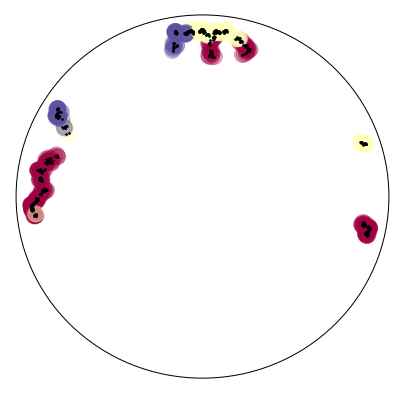

In [15]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
# ax.scatter(disk_x, disk_y, 
#             c=targ, cmap=cmap, s=20, marker='.',alpha=0.7)
ax.scatter(disk_x, disk_y, 
            c=targ, cmap=cmap, s=1000, marker='.',alpha=0.3)
ax.scatter(disk_x, disk_y, 
            c='k', s=10, marker='.')
boundary = plt.Circle((0,0), 1.05, fc='none', ec='k')
ax.add_artist(boundary)
ax.axis('off');
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
plt.show()

In [ ]:
#TODO: find a Block that has the most observations in it accross all monkeys.
#TODO: consider trying different nid_self neurons

In [ ]:
dat.shape

# TODO: clustering on x_values,y_values that show meaningful structure over long time scales
- prerequisite(?): find meaningful structure that is consistent over long time scales

Hierarchical Density-based Spatial Clustering of Applications with Noise (HDBSCAN) was used to partition the results of UMAP into sets.

In [311]:
x_values

array([-11.611993, -11.539447, -11.533755, ...,  18.097046,  18.0995  ,
        18.090406], dtype=float32)

In [ ]:
!pip install hdbscan

In [ ]:
import hdbscan


In [ ]:
from scipy.cluster.hierarchy import fcluster

clusterer = hdbscan.HDBSCAN()

In [ ]:
XY=np.stack(x_values,y_values)
clusterer.fit(XY)
Z = clusterer.single_linkage_tree_.to_numpy()
labels = fcluster(Z, 2, criterion='maxclust')

# TODO(feature augmentation): make histograms of single trials and compare to those of sets of trials.

# TODO: dev integrate and fire model, 
where M(t,tau)= the vector of number of spikes that occured for the i^th neuron in the time interval from t-tau to t. Distance/Loss metric should reward more spiking.

# TODO: try out which metrics actually reproduce the single trial patter that I've been gunning for